[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/haoxing-du/facts-in-llms/blob/main/Facts_in_GPT2_sm.ipynb)

In [1]:
! pip install einops git+https://github.com/neelnanda-io/Easy-Transformer/

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/neelnanda-io/Easy-Transformer/ to /tmp/pip-req-build-j7bz06ll
  Running command git clone -q https://github.com/neelnanda-io/Easy-Transformer/ /tmp/pip-req-build-j7bz06ll
     |████████████████████████████████| 365 kB 18.6 MB/s 
     |████████████████████████████████| 4.7 MB 27.9 MB/s 
     |████████████████████████████████| 115 kB 55.2 MB/s 
     |████████████████████████████████| 120 kB 54.2 MB/s 
     |████████████████████████████████| 212 kB 55.3 MB/s 
     |████████████████████████████████| 127 kB 56.5 MB/s 
     |████████████████████████████████| 6.6 MB 38.3 MB/s 
  Created wheel for easy-transformer: filename=easy_transformer-0.1.0-py3-none-any.whl size=16088 sha256=eaabb46e822ae00e701e4985a91a29ea7ddd0824c3c4f313afaf4ed4f668af9b
  Stored in directory: /tmp/pip-ephem-wheel-cache-p3_20rai/wheels/de/f1/0e/7a536e8f66757acbdbb9c6e17d00635da4804727d85c49e1ee

In [2]:
!nvidia-smi

Fri Sep  9 17:47:14 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P0    23W / 300W |      0MiB / 16160MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
from functools import *
import json
import pathlib
import os

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import einops
from tqdm import tqdm
from transformers import AutoModelForCausalLM, AutoConfig, AutoTokenizer

import matplotlib.pyplot as plt
import plotly.express as px
import plotly.io as pio
from plotly.subplots import make_subplots
import plotly.graph_objects as go
pio.renderers.default = "colab"

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# %%
from easy_transformer.utils import gelu_new, to_numpy, get_corner  # helper functions
from easy_transformer.hook_points import HookedRootModule, HookPoint
from easy_transformer.EasyTransformer import (
    EasyTransformer,
    TransformerBlock,
    MLP,
    Attention,
    LayerNormPre,
    PosEmbed,
    Unembed,
    Embed,
)
from easy_transformer.experiments import ExperimentMetric, AblationConfig, EasyAblation, EasyPatching, PatchingConfig

In [4]:
# load model
model_name = "gpt2"  # @param ['gpt2', 'gpt2-medium', 'gpt2-large', 'gpt2-xl', 'facebook/opt-125m', 'facebook/opt-1.3b', 'facebook/opt-2.7b', 'facebook/opt-6.7b', 'facebook/opt-13b', 'facebook/opt-30b', 'facebook/opt-66b', 'EleutherAI/gpt-neo-125M', 'EleutherAI/gpt-neo-1.3B', 'EleutherAI/gpt-neo-2.7B', 'EleutherAI/gpt-j-6B', 'EleutherAI/gpt-neox-20b']
model = EasyTransformer(model_name, use_attn_result=True)
if torch.cuda.is_available():
    model.to("cuda")

print(f"Number of parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad)}")
print("Reference: Hyperparameters for the model")
for hyper_param in model.cfg:
    print(hyper_param, model.cfg[hyper_param])

Number of parameters: 163049041
Reference: Hyperparameters for the model
d_model 768
d_head 64
n_heads 12
d_mlp 3072
n_layers 12
n_ctx 1024
eps 1e-05
d_vocab 50257
act_fn gelu_new
use_attn_scale True
use_local_attn False
model_name gpt2
model_type gpt2
use_attn_result True
checkpoint None
full_model_name gpt2


In [5]:
# some util functions
def show_tokens(tokens):
    # Prints the tokens as text, separated by |
    if type(tokens) == str:
        # If we input text, tokenize first
        tokens = model.to_tokens(tokens)
    text_tokens = [model.tokenizer.decode(t) for t in tokens.squeeze()]
    print("|".join(text_tokens))

def sample_next_token(
    model: EasyTransformer, input_ids: torch.Tensor, temperature=1.0, freq_penalty=0.0, top_k=0, top_p=0.0, cache=None
) -> torch.Tensor:
    assert input_ids.ndim == 1, "input_ids should be a 1D sequence of token ids"
    model.eval()
    with torch.inference_mode():
        all_logits = model(input_ids.unsqueeze(0))  # TODO: cache
    B, S, E = all_logits.shape
    logits = all_logits[0, -1]
    return logits

In [6]:
# sampling example
input = "Steve Jobs founded"
input_tokens = model.tokenizer.encode(input)

logits = sample_next_token(model, torch.LongTensor(input_tokens).to(device))

values, indices = torch.topk(logits, k=20)
print(f"Model name: {model_name}")
print(f"Input: {input}")
print(f"token {'':<9} logits")
for i in range(20):
    print(f"{model.tokenizer.decode(indices[i]) :<15} {values[i].item()}")

Model name: gpt2
Input: Steve Jobs founded
token           logits
 Apple          7.852551460266113
 the            6.380948066711426
 Microsoft      5.519965171813965
 a              4.980104446411133
 Google         4.520717620849609
 Facebook       4.05318546295166
 his            3.9590368270874023
 Intel          3.6390743255615234
 IBM            3.36337947845459
 and            3.302112579345703
 an             2.971888542175293
 Amazon         2.656680107116699
 two            2.385678768157959
 The            2.327566146850586
 one            2.209731101989746
 Fox            2.201173782348633
 Oracle         2.150117874145508
 Silicon        2.057069778442383
 Dell           1.9565372467041016
 Windows        1.931778907775879


# The CounterFact dataset

In [8]:
!wget https://rome.baulab.info/data/dsets/counterfact.json

with open("counterfact.json", "rb") as f:
    counterfact = json.load(f)

--2022-09-09 17:48:47--  https://rome.baulab.info/data/dsets/counterfact.json
Resolving rome.baulab.info (rome.baulab.info)... 35.232.255.106
Connecting to rome.baulab.info (rome.baulab.info)|35.232.255.106|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 45108470 (43M) [application/json]
Saving to: ‘counterfact.json’

counterfact.json    100%[===================>]  43.02M  19.7MB/s    in 2.2s    

2022-09-09 17:48:49 (19.7 MB/s) - ‘counterfact.json’ saved [45108470/45108470]



In [ ]:
# Filter dataset for things that GPT2sm knows
# To save time, skip to the next cell and load the filtered dataset
counterfact_gpt2sm_top1 = []

for data in tqdm(counterfact):
    rr = data["requested_rewrite"]
    input = rr["prompt"].format(rr["subject"])
    target = " " + rr["target_true"]["str"]
    false_target = " " + rr["target_new"]["str"]
    input_tokens = model.tokenizer.encode(input)
    target_tokens = model.tokenizer.encode(target)
    false_target_tokens = model.tokenizer.encode(false_target)
    logits = sample_next_token(model, torch.LongTensor(input_tokens).to(device))
    top_token = torch.argmax(logits).item()
    # model is considered to know the fact if the right answer is
    # the top suggested token
    if target_tokens[0] == top_token:
        counterfact_gpt2sm_top1.append(data)

In [9]:
!wget https://raw.githubusercontent.com/haoxing-du/facts-in-llms/main/counterfact_gpt2sm_top1.json

with open("counterfact_gpt2sm_top1.json", "rb") as f:
    counterfact_gpt2sm_top1 = json.load(f)

print(
    f"Model {model_name} knows {len(counterfact_gpt2sm_top1)} facts, which is {len(counterfact_gpt2sm_top1)/len(counterfact)} of the whole CounterFact data set."
)

--2022-09-09 17:48:51--  https://raw.githubusercontent.com/haoxing-du/facts-in-llms/main/counterfact_gpt2sm_top1.json
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2204406 (2.1M) [text/plain]
Saving to: ‘counterfact_gpt2sm_top1.json.1’

counterfact_gpt2sm_ 100%[===================>]   2.10M  --.-KB/s    in 0.02s   

2022-09-09 17:48:51 (98.9 MB/s) - ‘counterfact_gpt2sm_top1.json.1’ saved [2204406/2204406]

Model gpt2 knows 1248 facts, which is 0.056936904055841966 of the whole CounterFact data set.


([0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25],
 <a list of 26 Text major ticklabel objects>)

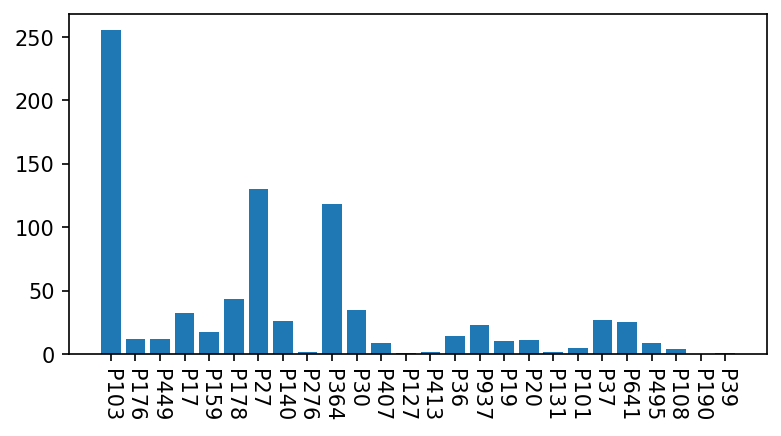

In [10]:
# Investigate the distribution of relation_ids

relation_ids = []
one_of_each = []
for data in counterfact_gpt2sm_top1:
    rr = data["requested_rewrite"]
    if rr["relation_id"] not in relation_ids:
        relation_ids.append(rr["relation_id"])
        one_of_each.append(data)

rel_id_counts = torch.zeros(len(relation_ids), dtype=int)
data_by_rel_id = {}
for rel_id in relation_ids:
    data_by_rel_id[rel_id] = []
for data in counterfact_gpt2sm_top1:
    rr = data["requested_rewrite"]
    rel_id = rr["relation_id"]
    # filter out the ones where the answer appears in the question
    if not rr["target_true"]["str"] in rr["subject"]:
        data_by_rel_id[rel_id].append(data)
        rel_id_counts[relation_ids.index(data["requested_rewrite"]["relation_id"])] += 1

plt.figure(dpi=150, figsize=(6,3))
plt.bar(relation_ids, rel_id_counts.numpy())
plt.xticks(rotation=-90)

One example from each relation ID:

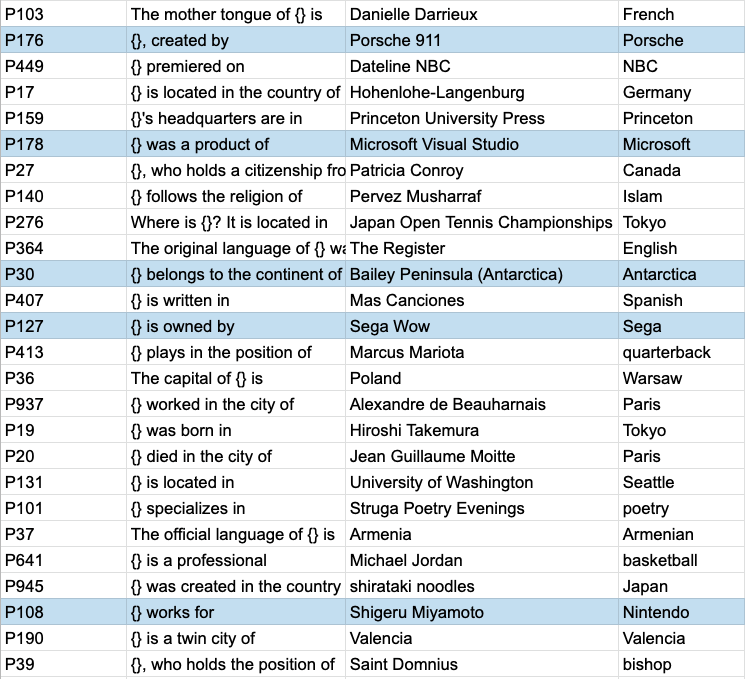

# Activation patching

How to make the model think that "Bill Gates founded" -> " Apple"?[link text](https://)

In [11]:
prompt_1 = 'Bill Gates founded'
response_1 = ' Microsoft'
logit_index_1 = model.to_tokens(response_1)[0][-1]
show_tokens(prompt_1)

prompt_2 = 'Steve Jobs founded'
response_2 = ' Apple'
logit_index_2 = model.to_tokens(response_2)[0][-1]
show_tokens(prompt_2)

model.reset_hooks()
uncorrupted_cache = {}
model.cache_all(uncorrupted_cache)
logits_1 = model(prompt_1)
model.reset_hooks()

uncorrupted_logits = model(prompt_2)
uncorrupted_log_probs = -F.log_softmax(uncorrupted_logits, dim=-1)
print("Uncorrupted neg log prob for", response_1, uncorrupted_log_probs[0, -1, logit_index_1].item())
print("Uncorrupted neg log prob for", response_2, uncorrupted_log_probs[0, -1, logit_index_2].item())

# Patch the residual stream from the Bill Gates run to the Steve Jobs run
# at the Jobs/Gates token, at the start of layer 7
layer = 7
position = 1

def patch_resid_pre(resid_pre, hook):
    uncorrupted_resid_pre = uncorrupted_cache[hook.name]
    # Move things on the Jobs/Gates token
    resid_pre[:, position] = uncorrupted_resid_pre[:, position]
    return resid_pre

corrupted_logits = model.run_with_hooks(prompt_2, fwd_hooks=[(f"blocks.{layer}.hook_resid_pre", patch_resid_pre)])
corrupted_log_probs = -F.log_softmax(corrupted_logits, dim=-1)
print("Corrupted (Residual) neg log prob for", response_1, corrupted_log_probs[0, -1, logit_index_1].item())
print("Corrupted (Residual) neg log prob for", response_2, corrupted_log_probs[0, -1, logit_index_2].item())

Bill| Gates| founded
Steve| Jobs| founded
Uncorrupted neg log prob for  Microsoft 2.8903255462646484
Uncorrupted neg log prob for  Apple 0.5577393174171448
Corrupted (Residual) neg log prob for  Microsoft 0.537916898727417
Corrupted (Residual) neg log prob for  Apple 4.753257751464844


Let's patch at all the heads and see which one(s) matter the most.

In [16]:
def patch_facts(fact_1, fact_2, label_1, label_2):
    pos_1 = len(model.to_tokens(fact_1).squeeze(0)) - 1
    pos_2 = len(model.to_tokens(fact_2).squeeze(0)) - 1
    tokens_pos = [pos_2, pos_1]

    source_facts = [fact_1, fact_2]
    target_facts = [fact_2, fact_1]
    for fact in source_facts:
        show_tokens(fact)
    print(f"Labels: {label_1, label_2}")

    source_labels = [label_1, label_2]
    target_labels = [label_2, label_1]

    source_logits = model.to_tokens(source_labels).squeeze()
    target_logits = model.to_tokens(target_labels).squeeze()

    def fact_transfer_score(model, target_dataset):
        logits = model(target_dataset)
        log_probs = F.log_softmax(logits, dim=-1)
        # logit target - logit source (positive by default)
        logit_diff = (
            log_probs[torch.arange(len(target_logits)), tokens_pos, target_logits]
            - log_probs[torch.arange(len(source_logits)), tokens_pos, source_logits]
        )

        return logit_diff.mean()

    # the position of "founded" in the target sentences, where to get the next token prediction
    print(f"Patched token positions: {tokens_pos}")

    metric = ExperimentMetric(fact_transfer_score, target_facts, relative_metric=False)
    config = PatchingConfig(
        source_dataset=source_facts,
        target_dataset=target_facts,
        target_module="attn_head",
        head_circuit="v",
        cache_act=True,
        verbose=False,
    )
    patching = EasyPatching(model, config, metric)
    result = patching.run_patching()
    normalized_result = (result - result.mean()) / result.std()
    px.imshow(
        result,
        # normalized_result,
        labels={"y": "Layer", "x": "Head"},
        color_continuous_scale="Blues",
        title="LogProb(target) - LogProb(source) after patching source to target",
    ).show()

In [17]:
# Example: 10.0 most prominent
fact_1 = "Bill Gates founded"
fact_2 = "Steve Jobs founded"
label_1 = " Microsoft"
label_2 = " Apple"
patch_facts(fact_1, fact_2, label_1, label_2)

Bill| Gates| founded
Steve| Jobs| founded
Labels: (' Microsoft', ' Apple')
Patched token positions: [2, 2]


100%|██████████| 12/12 [00:04<00:00,  2.72it/s]


In [18]:
# Example: 9.8 most prominent
fact_1 = "The official language of Germany is"
fact_2 = "The official language of Brazil is"
label_1 = " German"
label_2 = " Portuguese"
patch_facts(fact_1, fact_2, label_1, label_2)

The| official| language| of| Germany| is
The| official| language| of| Brazil| is
Labels: (' German', ' Portuguese')
Patched token positions: [5, 5]


100%|██████████| 12/12 [00:03<00:00,  3.21it/s]


Let's run this experiment on each of the 26 categories of facts in (filtered) CounterFact and see if there is any recognizable pattern. In order to do patching, we need a dataset of parallel facts, like "Steve Jobs founded Apple" and "Bill Gates founded Microsoft" so that we can patch the activations from one to the other. Fortunately, there is a "attribute_prompt" field in the CounterFact dataset, which is a similar fact with a different answer, e.g. the first entry in our filtered dataset:

In [ ]:
print(counterfact_gpt2sm_top1[0]["requested_rewrite"])
print(counterfact_gpt2sm_top1[0]["attribute_prompts"][0])

{'prompt': 'The mother tongue of {} is', 'relation_id': 'P103', 'target_new': {'str': 'English', 'id': 'Q1860'}, 'target_true': {'str': 'French', 'id': 'Q150'}, 'subject': 'Danielle Darrieux'}
J. R. R. Tolkien is a native speaker of


In [ ]:
# Run activation patching on the whole CounterFact-gpt2sm data set
# This also take a LONG time to run, so wget the result in next cell

results = {}
for rel_id in relation_ids:
    results[rel_id] = []
# dataset = data_by_rel_id["P176"]
for rel_id in relation_ids:
    for i in range(len(data_by_rel_id[rel_id])):
        rr = data_by_rel_id[rel_id][i]["requested_rewrite"]
        fact_1 = rr["prompt"].format(rr["subject"])
        fact_2 = data_by_rel_id[rel_id][i]["attribute_prompts"][0]
        label_1 = " " + rr["target_true"]["str"]
        label_2 = " " + rr["target_new"]["str"]
        pos_1 = len(model.to_tokens(fact_1).squeeze(0)) - 1
        pos_2 = len(model.to_tokens(fact_2).squeeze(0)) - 1
        tokens_pos = [pos_2, pos_1]

        source_facts = [fact_1, fact_2]
        target_facts = [fact_2, fact_1]

        source_labels = [label_1, label_2]
        target_labels = [label_2, label_1]

        source_logits = model.to_tokens(source_labels).squeeze()
        target_logits = model.to_tokens(target_labels).squeeze()

        metric = ExperimentMetric(fact_transfer_score, target_facts, relative_metric=False)
        config = PatchingConfig(
            source_dataset=source_facts,
            target_dataset=target_facts,
            target_module="attn_head",
            head_circuit="v",
            cache_act=True,
            verbose=False,
        )
        patching = EasyPatching(model, config, metric)
        result = patching.run_patching()
        results[rel_id].append(result)

In [ ]:
!wget https://github.com/haoxing-du/facts-in-llms/blob/main/act_patch_by_rel_id_2.pt?raw=true

with open("act_patch_by_rel_id_2.pt?raw=true", "rb") as f:
    results = torch.load(f)

--2022-09-09 06:55:22--  https://github.com/haoxing-du/facts-in-llms/blob/main/act_patch_by_rel_id_2.pt?raw=true
Resolving github.com (github.com)... 140.82.114.3
Connecting to github.com (github.com)|140.82.114.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://github.com/haoxing-du/facts-in-llms/raw/main/act_patch_by_rel_id_2.pt [following]
--2022-09-09 06:55:22--  https://github.com/haoxing-du/facts-in-llms/raw/main/act_patch_by_rel_id_2.pt
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/haoxing-du/facts-in-llms/main/act_patch_by_rel_id_2.pt [following]
--2022-09-09 06:55:22--  https://raw.githubusercontent.com/haoxing-du/facts-in-llms/main/act_patch_by_rel_id_2.pt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|18

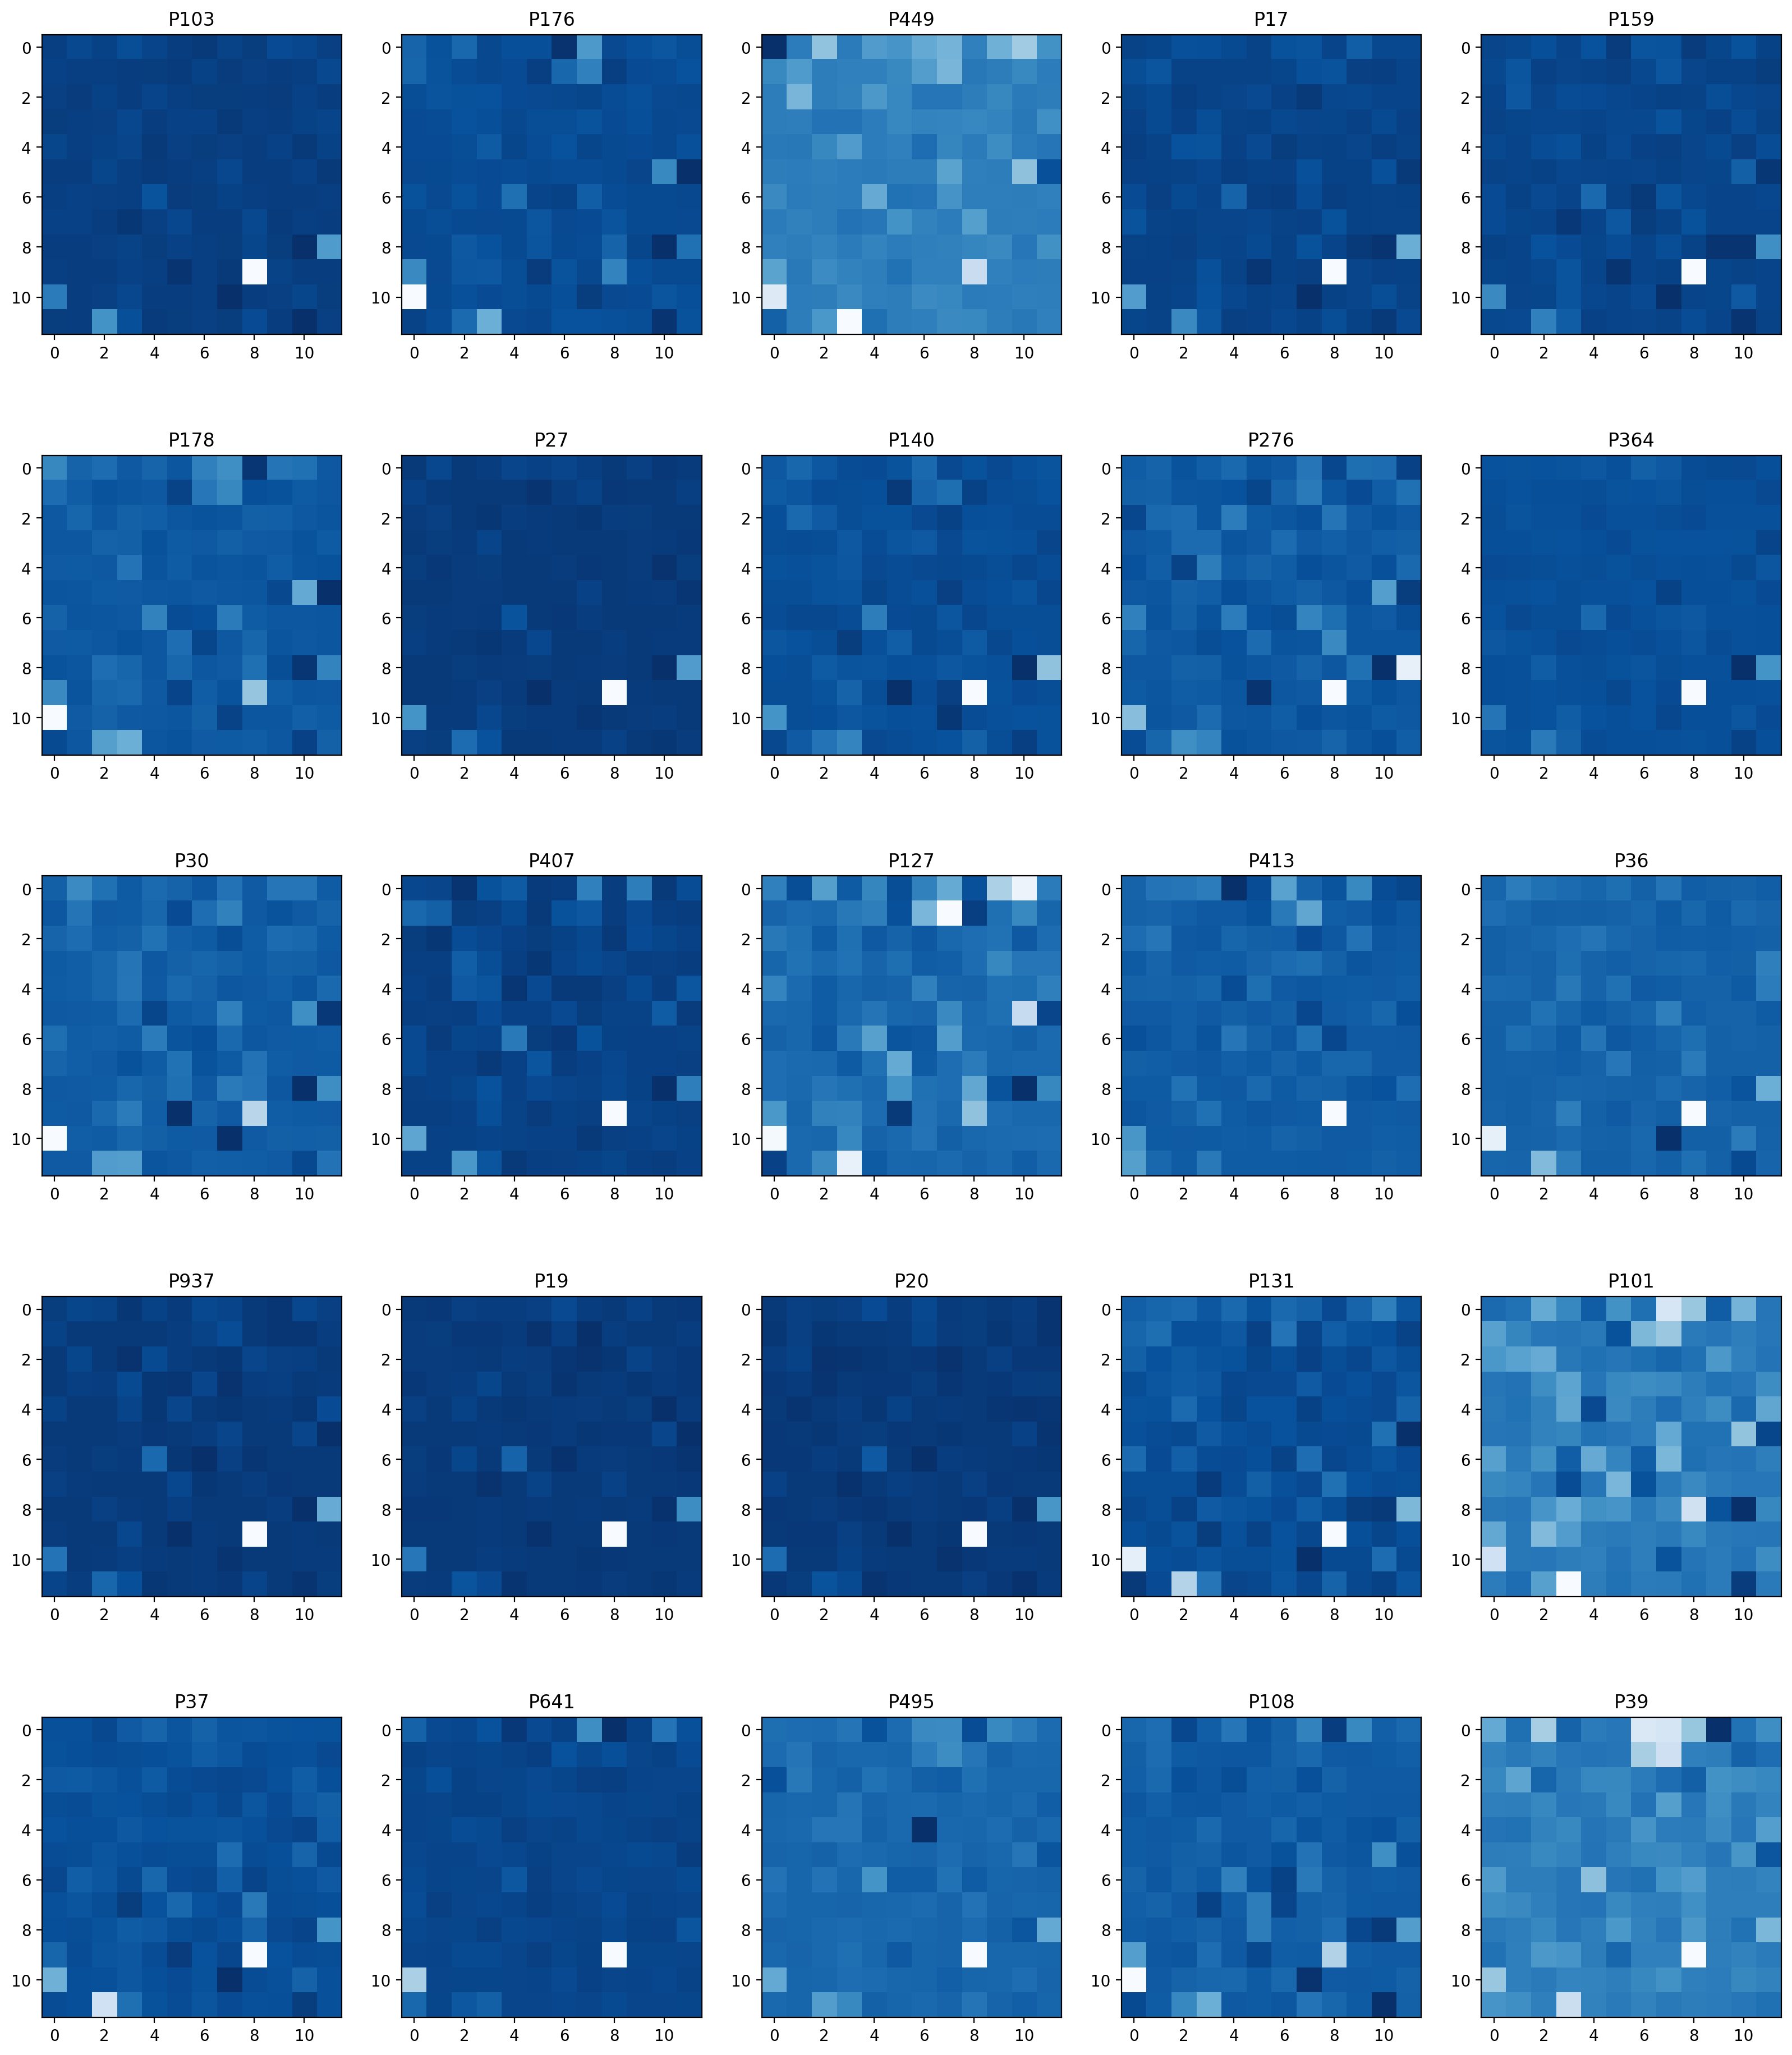

In [ ]:
# visualize result
fig = plt.figure(figsize=(20,24), dpi=200)
i = 0
for rel_id in results:
    if len(results[rel_id]) > 0:
        plt.subplot(5,5,i+1)
        plt.imshow(torch.stack(results[rel_id]).mean(dim=0), cmap='Blues')
        plt.title(rel_id)
        i += 1

# Which heads write most strongly in the right direction?

For these experiments, let's zoom in on a few of the relation IDs that have patterns that are most distinct from others, e.g. P176 ([product] is made by [company]), P17 ([city] is in [country]), P103 ([person] speaks [language]).

In [19]:
def make_dataset(rel_id):
    dataset = []
    labels = set()
    for data in data_by_rel_id[rel_id]:
        rr = data["requested_rewrite"]
        labels.add(rr["target_true"]["str"])
        labels.add(rr["target_new"]["str"])
        if rr["target_true"]["str"] not in rr["subject"]:
            dataset.append((rr["prompt"].format(rr["subject"]), rr["target_true"]["str"]))
    return dataset, labels

data_companies, companies = make_dataset("P176")
data_countries, countries = make_dataset("P17")
data_languages, languages = make_dataset("P103")
data_language2, language2 = make_dataset("P37")

In [20]:
def show_pp(m, xlabel="", ylabel="", title=""):
    """
    Plot a heatmap of the values in the matrix `m`
    """
    fig = px.imshow(
        m.T,
        title=title if title else "",
        color_continuous_scale="RdBu",
        color_continuous_midpoint=0,
    )

    fig.update_layout(
        coloraxis_colorbar=dict(
            title=f"Dot Product",
            thicknessmode="pixels",
            thickness=50,
            lenmode="pixels",
            len=300,
            yanchor="top",
            y=1,
            ticks="outside",
        ),
        xaxis_title="",
    )

    fig.update_layout(yaxis_title=ylabel, xaxis_title=xlabel)
    fig.show()

def writing_direction_heatmap(
    model,
    prompts, 
    mode="attn_out", 
    return_vals=False, 
    dir_mode = "R-W",
    unembed_mode = "normal", # or "Neel"
    title="",
):
    """
    Plot the dot product between how much each attention head
    output with `right-wrong`, the difference between the unembeds between
    the correct token and the average of some incorrect tokens
    """

    n_heads = model.cfg["n_heads"]
    n_layers = model.cfg["n_layers"]

    model_unembed = model.unembed.W_U.detach().cpu() #note that for GPT2 embeddings and unembeddings are tides such that W_E = Transpose(W_U)

    if mode == "attn_out": # heads, layers
        vals = torch.zeros(size=(n_heads, n_layers))
    elif mode == "mlp":
        vals = torch.zeros(size=(1, n_layers))
    else:
        raise NotImplementedError()

    N = len(prompts)
    for prompt in tqdm(prompts):
        right_tok = model.tokenizer.encode(" "+prompt["right"])
        right_dir = model_unembed[right_tok]
        wrong_dirs = []
        for wrong in prompt["wrongs"]:
            wrong_tok = model.tokenizer.encode(" "+wrong)
            wrong_dirs.append(model_unembed[wrong_tok[0]])
        wrong_dir = torch.stack(wrong_dirs).mean(dim=0)
        if dir_mode == "R-W":
            dire = (right_dir - wrong_dir).squeeze()
        elif dir_mode == "R":
            dire = right_dir.squeeze()
        elif dir_mode == "W":
            dire = wrong_dir.squeeze()
        else:
            raise NotImplementedError()

        model.reset_hooks()
        cache = {}
        model.cache_all(cache)

        logits = model(prompt["text"])

        for lay in range(n_layers):
            if mode == "attn_out": 
                cur = cache[f"blocks.{lay}.attn.hook_result"][0,-2,:,:]
            elif mode == "mlp":
                cur = cache[f"blocks.{lay}.hook_mlp_out"][:,-2,:]
            vals[:,lay] += torch.einsum("ha,a->h", cur.cpu(), dire.cpu())

    vals /= N
    show_pp(vals, xlabel="head no", ylabel="layer no", title=title)
    if return_vals: return vals

For example, look at the Gates/Microsoft case again. We can in fact take the difference between the right direction and the average direction of a set of wrong answers, which in this case is the set of other companies that we gathered from the dataset. It looks like whether or not to subtract the wrong answers doesn't make a qualitative difference, just makes things a bit less noisy.

In [ ]:
prompts_gates = [{"text": "Bill Gates founded",
           "right": "Microsoft",
           "wrongs": list(companies)}]

writing_direction_heatmap(model, prompts_gates, dir_mode="R-W", title="Dot product of head output with (right - wrong)")

100%|██████████| 1/1 [00:00<00:00, 16.47it/s]


In [ ]:
prompts_country = [{"text": "Heidelberg is located in the country of",
           "right": "Germany",
           "wrongs": list(countries)}]
writing_direction_heatmap(model, prompts_country, dir_mode="R-W", title="Dot product of head output with (right - wrong)")

100%|██████████| 1/1 [00:00<00:00, 21.34it/s]


In [21]:
def make_prompts(dataset, labels):
    prompts = []
    for data in dataset:
        temp = set(labels)
        temp.discard(data[1])
        prompts.append({"text": data[0], 
                                "right": data[1], 
                                "wrongs": list(temp)})
    return prompts

print(f"Dataset size: {len(data_companies)}")
print(data_companies)
writing_direction_heatmap(model, 
                          make_prompts(data_companies, companies), 
                          dir_mode="R-W", 
                          title="Dot product of head output with (right - wrong)")

Dataset size: 12
[('Windows Server 2003 is a product of', 'Microsoft'), ('Game Boy Advance SP is developed by', 'Nintendo'), ('Windows Live Mail is developed by', 'Microsoft'), ('Windows 2000, developed by', 'Microsoft'), ('MacBook Air is a product of', 'Apple'), ('Wii U is produced by', 'Nintendo'), ('Game Boy Advance, created by', 'Nintendo'), ('Windows Vista is a product of', 'Microsoft'), ('Windows 7 is a product of', 'Microsoft'), ('Game Boy Micro, produced by', 'Nintendo'), ('PlayStation Eye, created by', 'Sony'), ('Super Game Boy is a product of', 'Nintendo')]


100%|██████████| 12/12 [00:00<00:00, 30.59it/s]


In [ ]:
print(f"Dataset size: {len(data_countries)}")
print(data_countries)
writing_direction_heatmap(model, 
                          make_prompts(data_countries, countries), 
                          dir_mode="R-W", 
                          title="Dot product of head output with (right - wrong)")

Dataset size: 32
[('Hohenlohe-Langenburg is located in the country of', 'Germany'), ('Gazzola is located in the country of', 'Italy'), ('Kyoto University is located in the country of', 'Japan'), ('Medical College and Hospital, Kolkata, in', 'India'), ('Higashikagawa is located in the country of', 'Japan'), ('JVC Kenwood Victor Entertainment is located in the country of', 'Japan'), ('Valhalla Swimming Hall is located in the country of', 'Sweden'), ('Bahujan Vikas Aaghadi is located in the country of', 'India'), ('Nizhneserginsky District is located in the country of', 'Russia'), ('Kyōto Prefecture is located in the country of', 'Japan'), ('Bad Schwalbach is located in the country of', 'Germany'), ('Roman Catholic Archdiocese of Ljubljana, in', 'Slovenia'), ('Roman Catholic Archdiocese of Lucca is located in the country of', 'Italy'), ('Colegio Nacional de Buenos Aires is located in the country of', 'Argentina'), ('Palladam is located in the country of', 'India'), ('Bhinmal is located in

100%|██████████| 32/32 [00:01<00:00, 19.64it/s]


In [23]:
print(f"Dataset size: {len(data_language2)}")
print(data_language2)
writing_direction_heatmap(model, 
                          make_prompts(data_language2, language2), 
                          dir_mode="R", 
                          title="Dot product of head output with (right - wrong)")

Dataset size: 27
[('The official language of Armenia is', 'Armenian'), ('In England, an official language is', 'English'), ('In Serbia, the language spoken is', 'Serbian'), ('In Canary Islands, the language spoken is', 'Spanish'), ('The official language of Jersey is', 'English'), ('The official language of Croatia is', 'Croatian'), ('In Denmark, the language spoken is', 'Danish'), ('In Catalonia, the language spoken is', 'Catalan'), ('The official language of United States Virgin Islands is', 'English'), ('The official language of Guernsey is', 'English'), ('The official language of Bermuda is', 'English'), ('The official language of Bulgaria is', 'Bulgarian'), ('The official language of Canada is', 'English'), ('In United Kingdom, the language spoken is', 'English'), ('In Kingdom of the Netherlands, an official language is', 'Dutch'), ('The official language of Singapore is', 'English'), ('In Portugal, an official language is', 'Portuguese'), ('The official language of Dundee is', 'E

100%|██████████| 27/27 [00:01<00:00, 20.12it/s]


# Visualizing attention pattern

It sure looks like 9.8 and 10.0 are the two most important heads in answering the factual questions considered here. Let's visualize their attention patterns!

In [ ]:
def show_attention_patterns(model, heads, texts, mode="val", title_suffix=""):
    assert mode in ["attn", "val"] #value weighted attention or attn for attention probas
    assert type(texts) == list

    for (layer, head) in heads:
        cache = {}

        good_names = [f"blocks.{layer}.attn.hook_attn"]
        if mode == "val": 
            good_names.append(f"blocks.{layer}.attn.hook_v")
        model.cache_some(cache=cache, names=lambda x:x in good_names) # shape: batch head_no seq_len seq_len

        logits = model(texts)
        
        for i,text in enumerate(texts):
            assert len(list(cache.items())) == 1 + int(mode=="val"), len(list(cache.items()))
            toks = model.tokenizer(text)["input_ids"]
            words = [model.tokenizer.decode([tok]) for tok in toks]
            attn = cache[good_names[0]].detach().cpu()[i,head,:,:]
            if mode == "val":
                vals = cache[good_names[1]].detach().cpu()[i,:,head,:].norm(dim=-1)
                cont = torch.einsum("ab,b->ab", attn, vals)

            fig = px.imshow(attn if mode == "attn" else cont, 
                            title=f"{layer}.{head} Attention"+title_suffix, 
                            color_continuous_midpoint=0, 
                            color_continuous_scale="RdBu", 
                           labels={'y':'Queries', 'x':'Keys'})

            fig.update_layout(
                xaxis={"side": "top", "ticktext": words, "tickvals": list(range(len(words))), "tickfont": dict(size=8)},
                yaxis={"ticktext": words, "tickvals": list(range(len(words))), "tickfont": dict(size=8)},
            )
            fig.show()

heads = [(9, 8), (10, 0)]

In [ ]:
texts = ["According to Wikipedia, Bill Gates was born and raised in Seattle, Washington. In 1975, he and Allen founded Microsoft in Albuquerque, New Mexico."]
show_attention_patterns(model, heads, texts)

In [25]:
# Load WikiText-2
import requests
import hashlib
import zipfile

DATA_FOLDER = "."
DATASET = "2"
BASE_URL = "https://s3.amazonaws.com/research.metamind.io/wikitext/"
DATASETS = {
    "103": "wikitext-103-raw-v1.zip",
    "2": "wikitext-2-raw-v1.zip"
}
TOKENS_FILENAME = os.path.join(DATA_FOLDER, f"wikitext_tokens_{DATASET}.pt")

def maybe_download(url: str, path: str) -> None:
    """Download the file from url and save it to path. If path already exists, do nothing."""
    if os.path.exists(path):
        return
    print("Downloading:", url)
    response = requests.get(url)
    with open(path, "wb") as f:
        f.write(response.content)

path = os.path.join(DATA_FOLDER, DATASETS[DATASET])
maybe_download(BASE_URL + DATASETS[DATASET], path)
expected_hexdigest = {
    '103': "0ca3512bd7a238be4a63ce7b434f8935",
    '2': "f407a2d53283fc4a49bcff21bc5f3770"
}
with open(path, "rb") as f:
    actual_hexdigest = hashlib.md5(f.read()).hexdigest()
    assert actual_hexdigest == expected_hexdigest[DATASET]

print(f"Using dataset WikiText-{DATASET} - options are 2 and 103")
z = zipfile.ZipFile(path)
def decompress(split: str) -> str:
    return z.read(f'wikitext-{DATASET}-raw/wiki.{split}.raw').decode('utf-8')
train_text = decompress('train').splitlines()
val_text = decompress('valid').splitlines()
test_text = decompress('test').splitlines()
wiki_text = train_text + val_text + test_text

Downloading: https://s3.amazonaws.com/research.metamind.io/wikitext/wikitext-2-raw-v1.zip
Using dataset WikiText-2 - options are 2 and 103


In [ ]:
# Visualize some random WikiText snippet
texts = [wiki_text[355][:200]]
show_attention_patterns(model, heads, texts)

# Extracting knowledge?

Looks like both 9.8 and 10.0 track proper nouns in the text with their attention patterns. But what are they actually doing? Ideally, we would like to find the literal matrix that encodes the answer to the question of "Bill Gates founded ?"

The naive attempt is to look at the matrix (W_unembed @ W_O @ W_V @ W_embed) of heads 10.0 and 9.8.

In [48]:
layer = 10
head = 0
W_E = model.embed.W_E.half()
W_U = model.unembed.W_U.half()
W_O = model.blocks[layer].attn.W_O[head].half()
W_V = model.blocks[layer].attn.W_V[head].half()
OV_circuit = W_U @ W_O @ W_V @ W_E

In [ ]:
input = " Microsoft" # try " Apple", " Jobs", " Germany", " Japan", " Nintendo"
token = model.tokenizer.encode(input)
logits = OV_circuit[token[0]]
values, indices = torch.topk(logits, k=20)
print(f"Head: {layer}.{head}")
print(f"Input: {input}, num tokens: {len(token)}")
print("Output of OV circuit:")
print(f"token {'':<9} logit")
for i in range(20):
    print(f"{model.tokenizer.decode(indices[i]) :<15} {values[i].item()}")

Head: 10.0
Input:  Microsoft, num tokens: 1
Output of OV circuit:
token           logit
 Azure          8.4609375
 Cortana        7.96875
anka            7.5703125
unes            7.44140625
 Kinect         7.30078125
log             6.96484375
sers            6.75
chy             6.6796875
plets           6.47265625
 Sno            6.234375
 Rowling        6.02734375
ilies           5.83984375
 Xbox           5.83203125
ples            5.76171875
 DirectX        5.67578125
 bucket         5.65234375
atically        5.61328125
ingle           5.59765625
bles            5.5703125
OOL             5.52734375


Recall that 10.0 is one of the name-mover heads in Kevin's IOI circuit. And it sure looked like for the IOI dataset, 10.0 is simply copying the name of the IO. How much of what 10.0 does is simply copying?

In [ ]:
# How much of this head is simply copying?
rand_indices = torch.randperm(50257)[:200]
px.imshow(to_numpy(OV_circuit[rand_indices][:, rand_indices])).show()

def top_1_acc(OV_circuit):
    """
    This should take the argmax of each column (ie over dim=0) and return the fraction of the time that's equal to the correct logit
    """
    return torch.sum(torch.argmax(OV_circuit,dim=0)==torch.arange(0,50257,device=device)).item()/50257

print(top_1_acc(OV_circuit))

0.12509700141273852


In [ ]:
layer = 9
head = 8
W_O = model.blocks[layer].attn.W_O[head].half()
W_V = model.blocks[layer].attn.W_V[head].half()
OV_circuit = W_U @ W_O @ W_V @ W_E

In [ ]:
input = " Germany"
token = model.tokenizer.encode(input)
logits = OV_circuit[token[0]]
values, indices = torch.topk(logits, k=20)
print(f"Head: {layer}.{head}")
print(f"Input: {input}, num tokens: {len(token)}")
print("Output of OV circuit:")
print(f"token {'':<9} logit")
for i in range(20):
    print(f"{model.tokenizer.decode(indices[i]) :<15} {values[i].item()}")

Head: 9.8
Input:  Germany, num tokens: 1
Output of OV circuit:
token           logit
 Munich         12.703125
 Mü             12.6171875
Germany         12.2421875
 Dortmund       12.0546875
 Austria        12.03125
hof             11.9140625
 Germany        11.8828125
 Merkel         11.4296875
 Friedrich      11.328125
 Bundesliga     11.234375
geist           11.2109375
 Switzerland    10.9765625
stadt           10.96875
ischer          10.7421875
sch             10.453125
 Luxembourg     10.390625
 Cologne        10.234375
 GER            10.2265625
ische           10.203125
 Volks          9.9609375


In [ ]:
# How much of this head is simply copying?
rand_indices = torch.randperm(50257)[:200]
px.imshow(to_numpy(OV_circuit[rand_indices][:, rand_indices])).show()
print(top_1_acc(OV_circuit))

0.045068348687744994


However, this looks a bit too much like just bigram frequency.

In [49]:
bigram = W_U @ W_E

In [ ]:
input = " Microsoft" # try " Apple", " Jobs", " Germany", " Japan", " Nintendo"
token = model.tokenizer.encode(input)
logits = bigram[token[0]]
values, indices = torch.topk(logits, k=20)
print("Just embed unembed")
print(f"Input: {input}, num tokens: {len(token)}")
print("Output of OV circuit:")
print(f"token {'':<9} logit")
for i in range(20):
    print(f"{model.tokenizer.decode(indices[i]) :<15} {values[i].item()}")
#del bigram

Just embed unembed
Input:  Microsoft, num tokens: 1
Output of OV circuit:
token           logit
 Microsoft      8.9375
Microsoft       7.53125
microsoft       4.9453125
 Windows        4.51953125
 Nokia          4.1875
 Mozilla        3.994140625
 Xbox           3.9296875
 IBM            3.92578125
 Adobe          3.728515625
 Apple          3.708984375
 Redmond        3.671875
 Google         3.59765625
 Lenovo         3.525390625
Windows         3.48046875
 Comcast        3.349609375
 Cortana        3.3203125
 AMD            3.30859375
 Nintendo       3.26171875
 Intel          3.244140625
 NVIDIA         3.240234375


But something is still clearly special about 9.8 and 10.0: if one took a random head, the top suggestions are complete gibberish.

In [ ]:
del OV_circuit
del bigram

NameError: ignored

In [ ]:
layer = 10
head = 1
W_O = model.blocks[layer].attn.W_O[head].half()
W_V = model.blocks[layer].attn.W_V[head].half()
OV_circuit = W_U @ W_O @ W_V @ W_E

In [ ]:
input = " Germany"
token = model.tokenizer.encode(input)
logits = OV_circuit[token[0]]
values, indices = torch.topk(logits, k=20)
print(f"Head: {layer}.{head}")
print(f"Input: {input}, num tokens: {len(token)}")
print("Output of OV circuit:")
print(f"token {'':<9} logit")
for i in range(20):
    print(f"{model.tokenizer.decode(indices[i]) :<15} {values[i].item()}")

Head: 10.1
Input:  Germany, num tokens: 1
Output of OV circuit:
token           logit
SPA             2.701171875
apan            2.625
icc             2.60546875
icles           2.56640625
itar            2.505859375
seller          2.48046875
Els             2.44921875
ubi             2.42578125
 Gohan          2.412109375
wings           2.349609375
imens           2.3203125
pieces          2.318359375
iar             2.291015625
itals           2.287109375
ItemThumbnailImage 2.287109375
Topics          2.28125
 circ           2.279296875
Dad             2.275390625
 simultane      2.2734375
expr            2.26953125


# Identifying familiar heads in GPT-2 small

This is a bit unrelated to the main quest, but easy to do. We know that many heads in LLMs do one of four things: attend to the current token, attend to the previous token, attend to the first token, and induction. Let's quickly see where they are in GPT-2 small.

In [45]:
attn_cache = {}
def cache_attn(attn, hook):
    attn_cache[hook.name]=attn
def filter_hook_attn(name):
    split_name = name.split('.')
    return (split_name[-1]=='hook_attn')

# Current token score
current_scores_array = np.zeros((model.cfg['n_layers'], model.cfg['n_heads']))
def calc_current_score(attn_pattern, hook):
    current_stripe = torch.diagonal(attn_pattern, dim1=2, dim2=3, offset=0)
    current_scores = einops.reduce(current_stripe, 'batch index pos -> index', 'mean')
    current_scores_array[hook.layer()] = current_scores.detach().cpu().numpy()
# run on random WikiText snippet
current_logits = model.run_with_hooks(wiki_text[2054], fwd_hooks=[(filter_hook_attn, calc_current_score)])

# Prev token score
prev_scores_array = np.zeros((model.cfg['n_layers'], model.cfg['n_heads']))
def calc_prev_score(attn_pattern, hook):
    prev_stripe = torch.diagonal(attn_pattern, dim1=2, dim2=3, offset=-1)
    prev_scores = einops.reduce(prev_stripe, 'batch index pos -> index', 'mean')
    prev_scores_array[hook.layer()] = prev_scores.detach().cpu().numpy()
prev_logits = model.run_with_hooks(wiki_text[2054], fwd_hooks=[(filter_hook_attn, calc_prev_score)])

# First token score
first_scores_array = np.zeros((model.cfg['n_layers'], model.cfg['n_heads']))
def calc_first_score(attn_pattern, hook):
    first_stripe = attn_pattern[...,0]
    first_scores = einops.reduce(first_stripe, 'batch index pos -> index', 'mean')
    first_scores_array[hook.layer()] = first_scores.detach().cpu().numpy()
first_logits = model.run_with_hooks(wiki_text[2054], fwd_hooks=[(filter_hook_attn, calc_first_score)])

# Induction score
seq_len = 100
rand_tokens = torch.randint(1000, 10000, (4, seq_len))
rand_tokens_repeat = einops.repeat(rand_tokens, 'batch pos -> batch (2 pos)')
if torch.cuda.is_available():
    rand_tokens_repeat = rand_tokens_repeat.cuda()

induction_scores_array = np.zeros((model.cfg['n_layers'], model.cfg['n_heads']))
def calc_induction_score(attn_pattern, hook):
    # Pattern has shape [batch, index, query_pos, key_pos]
    induction_stripe = attn_pattern.diagonal(1-seq_len, dim1=-2, dim2=-1)
    induction_scores = einops.reduce(induction_stripe, 'batch index pos -> index', 'mean')
    # Store the scores in a common array
    induction_scores_array[hook.layer()] = induction_scores.detach().cpu().numpy()
induction_logits = model.run_with_hooks(rand_tokens_repeat, fwd_hooks=[(filter_hook_attn, calc_induction_score)])

Text(0.5, 0, 'Head')

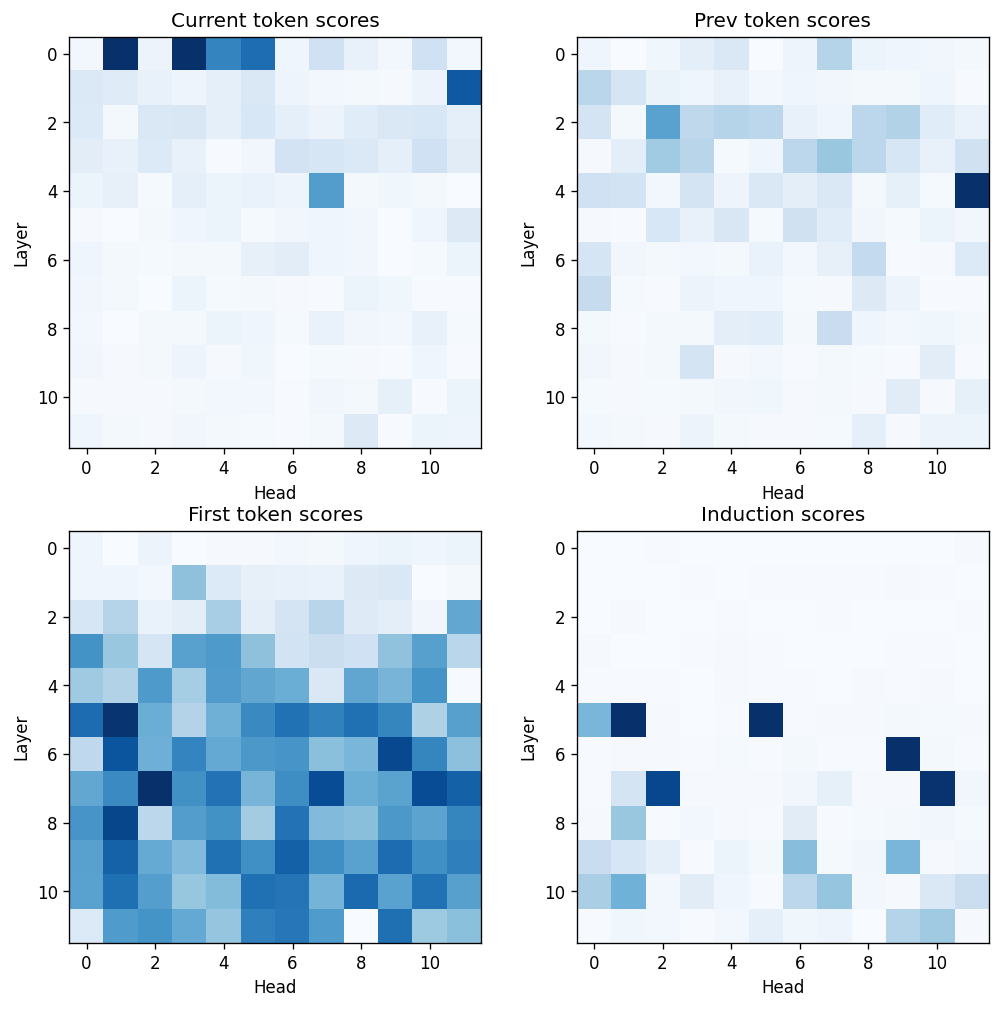

In [46]:
fig = plt.figure(figsize=(10,10), dpi=120)
plt.subplot(221)
plt.imshow(current_scores_array, cmap='Blues')
plt.title("Current token scores")
plt.ylabel("Layer")
plt.xlabel("Head")

plt.subplot(222)
plt.imshow(prev_scores_array, cmap='Blues')
plt.title("Prev token scores")
plt.ylabel("Layer")
plt.xlabel("Head")

plt.subplot(223)
plt.imshow(first_scores_array, cmap='Blues')
plt.title("First token scores")
plt.ylabel("Layer")
plt.xlabel("Head")

plt.subplot(224)
plt.imshow(induction_scores_array, cmap='Blues')
plt.title("Induction scores")
plt.ylabel("Layer")
plt.xlabel("Head")

Many of the previous token heads and induction-ish heads identified in Kevin's circuit show up here.